# Bootstrap sampling

In [1]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import * # imports all functions from definitions.py

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.

alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'
dir_path = '/home/hochatmstud/bene/'

In [2]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.
    
    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [3]:
station = 'Leipzig'

In [4]:
# Parameters
station = "Davis"


## Wind measurements

In [5]:
ds_wind = read_group('wind',station)

u = read_var(ds_wind,'u0')
v = read_var(ds_wind,'v0')

u_anomalie = anomalie('dayofyear',u)

v_anomalie = anomalie('dayofyear',v)

sea_u = sea(40,station,u)
sea_u_anomalie = sea(40,station,u_anomalie)

sea_v = sea(40,station,v)
sea_v_anomalie = sea(40,station,v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
#var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2] # 20 or 30 ; input timescale
its = 10000 # 10000 ; number of samples
#what = sys.argv[4] # anomalies ; what kind of anomalies
#DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True # allows rechunking in xr.apply_ufunc

if station == 'Leipzig':
    size = 7
elif station == 'Esrange':
    size = 11
elif station == 'Sodankyla':
    size = 4
elif station == 'Sodankyla_Kiruna':
    size = 11
elif station == 'CMOR':
    size = 9
elif station == 'RioGrande':
    size = 4
elif station == 'Davis':
    size = 7

line_width = 5

In [7]:
#u_anomalie
u_anomalie['name'] = 'statistical significance'

### for-loop via the lags

In [8]:
u_anomalie = u_anomalie.sel(alt=slice(80,100)).dropna('time')

In [9]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80,100)).dropna('days')

In [10]:
p = []

for lag in range(-40,41,1):
    #print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(u_anomalie, 
                                    its, 'time', replace=True, chunk=False, dim_max = size) 
    #print(rnd_arr)
    print("".ljust(line_width)+'{} samples generated'.format(its))
    ## load of composite dataarray
    #comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    #ds_comp = xr.open_dataarray(comp_file)*factor
    #print("".ljust(line_width)+'{} opened'.format(comp_file))
    
    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(g_kde, rnd_arr, sea_u_anomalie.sel(days=lag),\
                       input_core_dims=[['iteration'], []],\
                       vectorize=True, dask='parallelized',\
                       exclude_dims=set(("iteration",)),  \
                       output_core_dims=[[]], \
                       output_dtypes=[sea_u_anomalie['u0_mean'].dtype])
    print("".ljust(line_width)+'p-values calculated')
    # output the calculation                        
    #outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde['name'] = u_anomalie['name']
    #da_kde.to_netcdf(outfile_name)
    #print("".ljust(line_width)+'{} saved'.format(outfile_name))
    #del da_kde, rnd_arr, ds_comp
    #print()
    #da_kde.plot.scatter(y='alt', x='u0_mean')
    #da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde) 

     10000 samples generated
[ 3.28121088  5.27818707 10.14391497 ...  0.48311565  3.50871088
  2.8705    ]
[ 2.56339116  5.31408844  8.91722449 ... -0.00962245  2.62560884
  4.32131293]
[ 1.01498299  4.62196259  7.30762245 ... -0.24853061  1.41448299
  5.50508844]
[-1.01637075  3.86319048  5.9985     ... -0.57856463 -0.34195578
  6.27377891]
[-2.37666667  4.06257143  4.81308503 ... -0.05285714 -1.62037075
  6.79569728]
[-2.9097415   3.02367007  3.63345238 ...  0.28677551 -2.44848299
  7.17445578]
[-2.87747619  1.76697959  2.53732993 ... -0.18576531 -3.16287075
  7.09163265]
[-2.82997959  1.03889456  0.97656122 ... -0.52189796 -3.43765986
  6.64445578]
[-2.87278571  0.75145918 -0.22771429 ... -1.01060884 -3.84664966
  5.73541497]
[-2.63338095  0.54853061 -0.91576531 ... -1.51103741 -3.54066327
  4.12990476]
[-2.3158213   0.06122918  0.51566405 ... -2.17958673 -3.1362748
  7.15132267]
[ 3.28121088  5.27818707 10.14391497 ...  0.48311565  3.50871088
  2.8705    ]
[ 2.56339116  5.31408844

[ 1.16420748 -1.18633333 -4.05614626 ...  0.97636395  1.21160544
 -3.64070408]
[ 0.23387415 -0.45980952 -3.0612551  ...  1.5807483   2.96436395
 -3.45420748]
[-0.19495238  0.29438095 -2.19138095 ...  1.62410204  4.12827211
 -3.14843537]
[-1.44492177  1.03490476 -1.62477211 ...  1.24418367  4.97895578
 -2.8147585 ]
[-2.65227891  1.51080952 -1.33691497 ...  0.73228231  4.9545102
 -2.65686054]
[-3.25064966  1.46090476 -0.75387415 ...  0.54886054  4.21827551
 -2.55554422]
[-3.62121088  0.97209524 -0.05321769 ...  0.19610204  3.63783333
 -2.31583673]
[-3.20016327  0.22442857  0.78729592 ... -0.32547959  2.91430612
 -2.14144898]
[-2.16677891 -1.10742857  1.28343537 ... -1.21007143  2.79805442
 -1.3570102 ]
[-0.33779561 -3.18186281  1.76782313 ... -2.56361395  4.60179095
 -0.83214338]
     p-values calculated
     10000 samples generated
[ 0.43039796  0.75072789 -1.72186447 ... -1.90054422 -2.04561905
 -0.77519048]
[ 0.58539456  0.42012925 -2.8448022  ... -2.30494898 -0.73359864
 -1.42171429]

     10000 samples generated
[-9.10213605  1.99909524 -2.55577682 ... -3.37711565  2.10220748
 -4.11857143]
[-9.23292177  2.75938095 -4.41082287 ... -2.76388095  2.47761565
 -3.11433333]
[-8.55492177  2.91685714 -5.49263841 ... -1.84769388  2.60401361
 -1.31680952]
[-7.42254082  3.18609524 -7.32443511 ... -1.05231973  2.5725
  0.42033333]
[-6.29957483  3.57733333 -8.01139691 ... -0.55232653  1.84104422
  2.07009524]
[-4.14277211  3.54519048 -8.73904369 ... -0.7392483   0.74570068
  4.35780952]
[-2.35923129  2.88828571 -9.84664233 ... -0.67815986 -0.48479252
  6.32042857]
[ -0.87602041   1.77285714 -10.32345971 ...  -0.71042517  -1.11787755
   7.82614286]
[  0.59088095   0.50157143 -10.35703009 ...  -0.69842857  -1.74160204
   8.4812381 ]
[  2.05045238  -1.01142857 -10.33611565 ...  -0.2005034   -1.78933673
   7.07352381]
[ 3.02095264  1.38621245 -9.08019139 ...  0.29377891  0.98396599
  5.83469048]
[-9.10213605  1.99909524 -2.55577682 ... -3.37711565  2.10220748
 -4.11857143]
[-9.23292

[-6.35090476 -3.24728571 -4.39519388 ...  2.77596939  2.7262517
  6.04329932]
[-4.58595238 -4.58954082 -2.77055782 ...  2.97168027  2.87834694
  6.27428912]
[-2.61880952 -4.94420408 -1.65216327 ...  3.20805102  2.57357143
  6.37094218]
[-0.60347619 -4.72615646 -0.03971769 ...  3.13111224  1.90203741
  6.2050034 ]
[ 0.42609524 -4.45746939  1.15727891 ...  3.5082585   0.81036395
  5.66358503]
[ 1.79247619 -4.04822109  2.66821088 ...  4.22443878  0.28381293
  5.50530952]
[ 2.6367483  -2.2412602   0.79367661 ...  4.38665476 -0.88317687
  5.63100466]
     p-values calculated
     10000 samples generated
[ 1.67008503  2.3367585   1.09338776 ... -2.59437755  3.12181293
  1.11234014]
[ 0.31865646  1.74310204  0.94901701 ... -2.42742517  3.89954082
 -0.15358844]
[-0.48991156  2.29581973  0.43008163 ... -1.7685068   4.28908163
 -1.13273129]
[-0.48795918  3.7714966  -1.02734354 ... -0.52626531  3.79668367
 -2.16302041]
[-0.43036054  5.19087415 -2.53994898 ...  0.13480272  3.69138095
 -2.59059864]

     10000 samples generated
[-0.18496259  1.10157823 -0.62097279 ... -1.21144898  0.67938095
  7.82906122]
[ 1.78361224  1.30454422 -1.1627585  ... -0.02332313  0.774
  8.66347619]
[ 3.56668027  1.90087415 -1.49489116 ...  0.98257483  0.80480952
  8.52160204]
[ 5.54423129  2.36101701 -1.47658503 ...  2.051       0.92828571
  8.32293878]
[ 6.52154422  2.86430272 -0.92040136 ...  1.85434354  1.13366667
  7.25092857]
[ 7.09596259  2.75406803 -0.27237075 ...  1.59235714  1.41809524
  5.25491156]
[7.23394898 2.58932313 0.19469388 ... 1.30311565 1.38619048 3.68506122]
[7.35408503 2.70440476 1.33145238 ... 0.70583673 0.97180952 2.37138776]
[ 7.3982381   2.91607823  2.47992517 ...  0.04454422 -0.09795238
  0.24301361]
[ 6.78496259  2.57665986  3.23892517 ...  0.08836054 -1.10938095
 -2.33637755]
[ 4.14827682  1.62255736  3.04515391 ...  0.47072449 -2.2372381
 -2.4337568 ]
[-0.18496259  1.10157823 -0.62097279 ... -1.21144898  0.67938095
  7.82906122]
[ 1.78361224  1.30454422 -1.1627585  ... -0

[ 0.05982993  1.43609524 -1.42677211 ... -3.25101701  5.95871429
 -4.58296259]
[-0.09327551  1.67984354 -1.77709524 ... -2.05637755  6.49014966
 -4.95051701]
[ 0.00927551  1.38895238 -2.17529252 ... -1.71279592  6.96313265
 -5.47082993]
[-0.6260102   0.27343197 -2.17590136 ... -1.85327891  6.91326531
 -5.05430952]
[-1.98282313 -0.28397959 -2.18985034 ... -1.75277211  7.14238776
 -4.7670034 ]
[-4.79439848 -3.1471651  -1.7933629  ... -2.39313992  6.50765468
 -2.37995604]
     p-values calculated
     10000 samples generated
[ 0.16638776 -3.48473469 -4.86166327 ...  2.36528231  2.7010068
 -0.90034354]
[-1.65157823 -4.73812585 -2.48165306 ...  2.64203401  3.17864286
 -1.26920068]
[-2.72167347 -5.10939796 -0.24414966 ...  2.25171769  2.84187075
 -1.66132653]
[-3.18903061 -4.57914626  1.2107585  ...  1.57595918  2.25352041
 -2.22170068]
[-3.43471088 -3.74873469  1.97126531 ...  0.64065986  1.39439116
 -2.86573469]
[-3.43535714 -2.94331293  2.42498639 ... -0.26004082  1.27695578
 -2.54796599]

     10000 samples generated
[ 1.24027891  1.58210204 -1.58869048 ...  3.46542857 -4.9502483
  3.97114286]
[-0.34452721  1.62663946 -4.80257483 ...  3.19466327 -5.51121769
  4.21857143]
[-1.58408163  1.8882449  -6.34671088 ...  2.22015646 -5.81682653
  4.35928571]
[-1.75016667  2.48094218 -7.87741837 ...  0.46815306 -5.72438776
  4.36461905]
[-1.97959524  3.08839116 -8.40961565 ... -1.12289456 -5.43123469
  4.85961905]
[-1.86731293  3.28851361 -8.15421088 ... -2.13985714 -4.35441837
  5.50266667]
[-2.35126531  3.29820748 -7.30279932 ... -2.87151701 -2.59362245
  5.98471429]
[-2.63056122  3.47998639 -6.52081973 ... -3.09743878 -0.96290136
  5.8072381 ]
[-2.65597279  3.65286735 -5.33061905 ... -3.48016327  0.54451361
  5.2817619 ]
[-2.52309864  4.84453401 -3.89554082 ... -3.48581293  1.07430612
  4.38747619]
[-3.14502198  5.73607659 -2.80510099 ... -4.02998168  0.77564809
  5.53201635]
[ 1.24027891  1.58210204 -1.58869048 ...  3.46542857 -4.9502483
  3.97114286]
[-0.34452721  1.62663946 

[ 1.59013605  1.76458844 -4.45631293 ... -1.21766667  3.74485374
  2.56802721]
[ 1.01592517  1.62392857 -4.24631973 ... -0.95795238  3.63787755
  2.67937415]
[ 0.43221088  1.76934014 -4.03270068 ... -1.32247619  3.96627891
  2.08944558]
[ 0.30151701  1.27535714 -4.12322789 ... -1.41895238  4.68782993
  0.82623129]
[ 1.07833673 -0.09767347 -2.99081633 ... -0.91652381  5.58612585
 -0.84876531]
[ 2.75919872 -1.03360002 -1.59343197 ... -4.09376361  8.61388004
  0.62231988]
     p-values calculated
     10000 samples generated
[ 6.95319728 -0.70129932  3.85535034 ...  0.55756803  0.29488435
  3.67293878]
[ 8.87796259 -0.63627551  3.57420408 ...  0.84710204  0.94414286
  2.85502721]
[ 9.80138435 -0.43120748  3.69043537 ...  1.46163605  1.56343537
  1.88007483]
[10.18212925  0.01727891  3.41440476 ...  2.30113946  2.73980272
  1.22843537]
[10.15422449  0.0722415   2.17134694 ...  3.21639456  3.28278571
  1.15694558]
[10.05320408 -0.84647959  0.83769728 ...  3.36230272  3.28160544
  1.13588095

     10000 samples generated
[ 0.09380612  3.1285      0.60780952 ...  2.2529932  -5.24884014
 -0.17040476]
[ 2.18955102  3.0162517   0.917      ...  1.71721769 -5.61851701
 -1.02891497]
[ 3.98006122  2.89969048  1.32233333 ...  0.57781633 -5.15919048
 -2.02071429]
[ 5.04102381  2.89626871  1.38619048 ...  0.36768367 -4.3612381
 -3.02867007]
[ 5.40036735  2.16381293  1.6282381  ... -0.13272789 -3.46951361
 -3.29591837]
[ 5.20895238  0.99856122  1.46647619 ... -0.4760102  -2.79453061
 -3.25203741]
[ 4.63818367  0.42367687  0.60809524 ... -0.69288776 -1.79282313
 -2.51986395]
[ 4.10584694  0.03512925  0.09466667 ... -0.18733673 -0.33730612
 -1.31941837]
[ 3.64288776 -0.46128912 -0.4137619  ...  0.46651361  0.61737755
 -0.32365306]
[ 2.79664966 -1.143       0.08261905 ...  1.31980612  0.16914966
  0.69176871]
[ 2.2659707  -1.01263265  1.68041187 ...  2.92572727 -0.5957619
  0.46794218]
[ 0.09380612  3.1285      0.60780952 ...  2.2529932  -5.24884014
 -0.17040476]
[ 2.18955102  3.0162517  

[-3.02863605  1.8062585   4.47371088 ...  6.49117007 -4.03106463
  0.30666667]
[-2.38870408  2.53248639  3.5659966  ...  7.02432653 -3.57522109
  0.96243537]
[-1.66185714  3.22121088  2.91580612 ...  6.5507483  -3.27857823
  1.46496599]
[-0.53540816  2.61984694  2.50002381 ...  5.16103741 -2.63754762
  1.43643197]
[ 1.34952381  1.34412245  2.69596939 ...  4.68570748 -1.59221429
  0.72838095]
[ 2.9494966   0.84723129  2.8274898  ...  3.94222109 -0.37602721
  0.04377211]
[ 3.28540476e+00  2.51020408e-03  2.48499320e+00 ...  3.45491837e+00
  1.16497959e+00 -6.21091837e-01]
[ 2.65561905 -0.49233412  1.94022109 ...  3.01067687  2.26140476
 -0.93326871]
[ 2.65238043  3.15083909  0.42016837 ...  4.12786702  2.49559001
 -1.373677  ]
     p-values calculated
     10000 samples generated
[-2.50177891 -0.80647619 -4.5111978  ... -2.27389116  2.49746259
  4.80557143]
[-2.6927415  -2.50480952 -4.43684249 ... -0.72701361  1.52612245
  3.46747619]
[-2.8102381  -3.92671429 -4.09569963 ...  0.37436395 

     10000 samples generated
[-1.33038226 -1.20177551  1.39815646 ... -0.13527211  1.39607483
 -1.80741497]
[-0.41781606 -0.99560884  2.61045238 ...  0.2745034   1.08258163
 -1.19760884]
[ 0.92177996 -0.0432415   2.88991837 ...  0.75563946  0.56279252
 -0.62985034]
[ 1.6398472   1.31561224  2.73380612 ...  0.92376531  0.56080952
 -0.15922789]
[1.47130037 3.00685374 2.36709524 ... 1.29390136 0.42963265 0.25293878]
[1.26132025 4.55160884 1.81015986 ... 1.26617007 0.58860544 1.24328231]
[0.63326583 5.7184898  0.97058503 ... 0.74372449 0.80531633 2.30629252]
[-0.32363318  5.50329592 -0.2140102  ...  0.47942177  0.90827891
  3.04161565]
[-0.77500628  4.97682313 -1.16642517 ...  1.36043197  0.78363605
  3.13757823]
[-1.38161224  3.69931973 -1.85102381 ...  2.47110204  0.86235034
  3.06332653]
[ 0.1861719   1.40136565 -2.20043207 ...  2.90864914  2.64502041
  1.47359184]
[-1.33038226 -1.20177551  1.39815646 ... -0.13527211  1.39607483
 -1.80741497]
[-0.41781606 -0.99560884  2.61045238 ...  0.

[ 1.64117007  4.34578571 -0.72752381 ... -0.20305442  4.88677891
  2.21078571]
[ 0.52026871  3.93090476 -0.1944966  ... -1.3220102   3.58287075
  2.55118027]
[-0.38486735  3.4620068   0.00977891 ... -1.71433673  2.83038776
  3.00389456]
[-1.46364966  3.36688435 -0.06262585 ... -1.32518027  2.19280272
  2.49203401]
[-1.74268367  3.5769966  -0.43316667 ... -0.15244558  1.68107143
  1.12640816]
[-1.08670748  3.27613265 -1.22890136 ...  1.05982653  1.89744558
 -0.26464966]
[-1.6240263   2.61701548  0.58180952 ...  2.09795063  4.11877564
 -0.81898609]
     p-values calculated
     10000 samples generated
[-3.73707483 -3.82714966  2.0330102  ... -0.42942517 -5.81929592
  0.43504082]
[-3.07914286 -3.27051701  2.39508503 ... -1.21613605 -5.42044898
  1.03066667]
[-2.21326531 -2.60819728  2.46510884 ... -1.22551701 -5.17404082
  1.0757381 ]
[-1.44965986 -1.79628912  2.82419048 ... -0.87881293 -4.97706803
  1.47695238]
[-0.84056122 -1.23227551  2.30254762 ... -1.02183673 -3.97815306
  2.04177551

     10000 samples generated
[ 0.56618027 -4.84566667 -1.20856803 ... -4.54714286  5.24002381
  8.70414286]
[ 1.47915986 -4.83961224 -1.35259864 ... -3.98628571  4.70814626
  8.65738095]
[ 2.41056803 -5.28794558 -1.46038435 ... -3.03109524  4.22628912
  7.61009524]
[ 3.5690034  -5.62889116 -1.66960884 ... -2.15771429  3.81210544
  6.4752381 ]
[ 4.64       -5.18542177 -1.67487075 ... -1.23490476  3.41972109
  5.42638095]
[ 4.93489796 -4.28293878 -2.63089796 ... -0.14266667  3.04793537
  4.32585714]
[ 4.40419048 -2.82460544 -3.31438095 ...  0.92771429  2.26771429
  3.69542857]
[ 3.66047279 -1.34441497 -3.776      ...  1.17285714  1.54859184
  3.49347619]
[ 3.15808503 -0.42445578 -3.72137415 ...  1.66114286  0.8030102
  2.88685714]
[ 3.0227551   0.23720748 -3.82401701 ...  1.6722381   0.69538095
  2.10857143]
[ 3.41602063  1.02080798 -1.55968027 ...  1.07922006 -0.18171184
  1.28337755]
[ 0.56618027 -4.84566667 -1.20856803 ... -4.54714286  5.24002381
  8.70414286]
[ 1.47915986 -4.83961224

[-4.98068027 -0.78671429  2.91006122 ...  1.52996599  0.48593878
 -2.65819048]
[-5.05814172 -0.8165034   3.99082732 ... -0.0959427   0.84915385
 -0.32074568]
     p-values calculated
     10000 samples generated
[-4.11754422  0.70030612 -0.1247619  ...  0.90522789 -1.10870748
 -0.11393537]
[-4.84979932  0.22443197 -0.39542857 ...  0.09171088 -0.81080612
 -1.0695068 ]
[-5.23154762 -0.83365986 -0.23828571 ... -0.67135374 -0.42207483
 -1.77276531]
[-5.8112449  -2.23432313  0.12019048 ... -1.68881633 -0.51741156
 -2.15832653]
[-6.72737075 -3.23796259  0.34571429 ... -3.26466667 -0.17809184
 -1.63789116]
[-7.38482653 -3.66492857  0.14147619 ... -4.43702041  0.19815986
 -0.93316327]
[-7.79346599 -3.6417483   0.20347619 ... -5.55505782  1.25447619
 -0.58194898]
[-7.25167007 -3.52312245  0.12004762 ... -6.94706803  2.3550068
 -0.67759184]
[-6.27911224 -3.40914966  0.19385714 ... -7.99456463  3.06945918
 -0.72461224]
[-4.6719932  -3.15458163  0.21809524 ... -8.31398299  3.98529932
 -0.9887585 ]

[-6.81271429  0.33040476  7.29340816 ...  4.82997619 -0.88873469
  2.19685714]
[-6.0492381   0.37040136  7.24430272 ...  5.31832993 -2.40182313
  2.0592381 ]
[-5.41742857  0.42426531  6.76563605 ...  5.8800034  -3.09128231
  1.28761905]
[-3.80852381  1.10052381  6.58695918 ...  5.90662925 -3.40505782
 -0.06747619]
[-1.6497619   0.60129932  6.59307823 ...  5.77719388 -3.18218027
 -1.03071429]
[ 0.14433333 -0.20694898  6.55928571 ...  5.49931293 -3.41885374
 -2.28485714]
[ 1.16752381 -0.38919728  5.86277891 ...  4.83458163 -3.80977551
 -3.0547619 ]
[ 1.88495238 -0.21509864  4.81821429 ...  4.36803741 -4.19434014
 -2.93952381]
[ 2.0462381   0.26103741  2.98581293 ...  3.08819048 -3.91112245
 -2.13914286]
[ 1.37238095  0.47345578  0.94030272 ...  1.48491497 -2.79622109
 -2.07721088]
[-1.31293132  0.97918158 -0.50847619 ... -2.5443762  -1.20518302
 -1.90306803]
[-6.81271429  0.33040476  7.29340816 ...  4.82997619 -0.88873469
  2.19685714]
[-6.0492381   0.37040136  7.24430272 ...  5.31832993

In [11]:
p_comp =  xr.concat(p, dim = 'days')
p_comp['days'] = range(-40, 40+1)
p_comp = p_comp.where(p_comp['u0_mean'] < 0.05, other = -0.05)

In [12]:
#p_comp

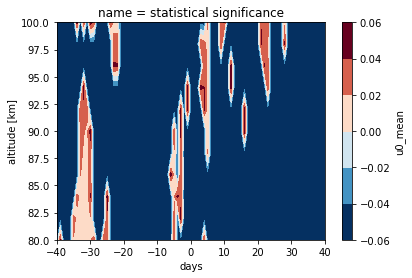

In [13]:
p_comp['u0_mean'].plot.contourf(x='days')